# Single-objective BO -- chemical representation comparison

In this notebook, we will explore BO for a reaction optimization task.

We will

1. examine different chemical reactions
2. code single-objective BO
3. code multi-objective BO

### install and import

In [5]:
#!pip install git+https://github.com/austin-mroz/summit.git@mac-implementation gauche rdkit matplotlib baybe[chem]

In [6]:
## install and import

import numpy as np
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt

# Exploring chemical representations

Here, we explore different ways to encode chemical systems, including one-hot encoding (OHE), extended connectivity fingerprints, and grpahs.

For this demonstration, we will calculate the chemical representations for the catalysts featured in our case study. 

The catalyst options are presented in Figure 1.

<h5 align="center">
<img src="../imgs/catalyst_options.png" class="img-fluid" width="250">

Figure 1. The catalyst options included in this study.
</h5>

Let's load the smiles strings from the github!

In [7]:
catalyst_smiles = pd.read_csv(pathlib.Path.cwd() / pathlib.Path("tutorial-resources/suzuki_miyaura_catalysts.csv"))
ligand_smiles = pd.read_csv(pathlib.Path.cwd() / pathlib.Path("tutorial-resources/suzuki_miyaura_ligands.csv"))

print(ligand_smiles)

  name                                             smiles
0   L1  CC(C)c4cc(C(C)C)c(c1ccccc1P(C2CCCCC2)C3CCCCC3)...
1   L2          CCc1cccc(CC)c1c2ccccc2P(C3CCCCC3)C4CCCCC4
2   L3    CC(C)c1cccc(C(C)C)c1c2ccccc2P(C3CCCCC3)C4CCCCC4
3   L4  CC7(C)c3cccc(P(c1ccccc1)c2ccccc2)c3Oc6c(P(c4cc...
4   L5                      C3CCC(P(C1CCCCC1)C2CCCCC2)CC3
5   L6             P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3
6   L7                        CC(C)(C)P(C(C)(C)C)C(C)(C)C


In [8]:
ligand_list = list(ligand_smiles['smiles'])
print(ligand_list)

['CC(C)c4cc(C(C)C)c(c1ccccc1P(C2CCCCC2)C3CCCCC3)c(C(C)C)c4', 'CCc1cccc(CC)c1c2ccccc2P(C3CCCCC3)C4CCCCC4', 'CC(C)c1cccc(C(C)C)c1c2ccccc2P(C3CCCCC3)C4CCCCC4', 'CC7(C)c3cccc(P(c1ccccc1)c2ccccc2)c3Oc6c(P(c4ccccc4)c5ccccc5)cccc67', 'C3CCC(P(C1CCCCC1)C2CCCCC2)CC3', 'P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3', 'CC(C)(C)P(C(C)(C)C)C(C)(C)C']


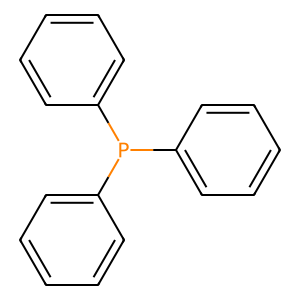

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

# first, generate the rdkit molecule object from the smiles
mol_L6 = Chem.MolFromSmiles('P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3')
Draw.MolToImage(mol_L6)

In [10]:
# create an rdkit molecule from the smiles
rdmols = [Chem.MolFromSmiles(smiles) for smiles in ligand_list]


In [11]:
from rdkit.Chem import AllChem
fpgen = AllChem.GetMorganGenerator(radius=3)
morgan_fingerprints = [fpgen.GetSparseCountFingerprint(mol) for mol in rdmols]

In [12]:
def visualize_fingerprint_info(fp):
    print("Number of elements: ", fp.size)
    print("Types of entries: ", set(list(fp)))
    print("Number of Ones: ", np.count_nonzero(fp))
    plt.vlines(
        [i for i in range(fp.size) if fp[i] > 0.5], ymin=0, ymax=300
    )  # 300 gives a nice aspect ratio
    plt.vlines(fp.size, ymin=0, ymax=0.0)  # dummy to calibrate scale
    plt.gca().set_aspect("equal")

We can visualize the sparsity of the fingerprint!

Number of elements:  2048
Types of entries:  {0, 1}
Number of Ones:  51


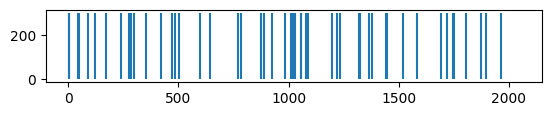

In [13]:
fp = fpgen.GetFingerprintAsNumPy(rdmols[0])
visualize_fingerprint_info(fp)

## MORDRED molecular descriptors

In [14]:
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc_2D = Calculator(descriptors, ignore_3D=True)
calc_3D = Calculator(descriptors, ignore_3D=False)
print(f"the length of the 2D descriptors is: {len(calc_2D)}")
print(f"the length of the 3D descriptors is: {len(calc_3D)}")

the length of the 2D descriptors is: 1613
the length of the 3D descriptors is: 1826


In [15]:
df_2D = calc_2D.pandas(rdmols)
df_3D = calc_3D.pandas(rdmols)

100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


# single-objective BO

In this example, we are going to compare the performance of different chemical representations for the Suzuki-Miyaura cross-coupling reaction emulator that we explored earlier with Web-BO.

## description of case study

For this example, we will explore an optimization case study that takes advantage of existing reaction emulators to acquire the experimental measurements.

This case study concerns optimizng the coupling of 3-bromoquinoline with 3,5-dimehtylisoxazole-4-boronic acid pinacol ester in the presence of 1,8-diazobicyclo[5.4.0]undec-7-ene (DBU) and THF/water, Figure 1.

<h5 align="center">
<img src="../imgs/reizman_reaction.png" class="img-fluid" width="400">

Figure 1. Suzuki-Miyaura cross-coupling reaction involved in this case study.
</h5>

The associated parameter space for this optimization task is detailed in Figure 2.

<h5 align="center">
<img src="../imgs/parameter_space.png" class="img-fluid" width="400">

Figure 2. Parameter space spanned by this case study includes 3 continuous variables (catalyst loading, temperature, and residence time) and 1 categorical variable (catalyst).
</h5>

The catalyst options are presented in Figure 3.

<h5 align="center">
<img src="../imgs/catalyst_options.png" class="img-fluid" width="400">

Figure 3. The catalyst options included in this study.
</h5>

This case study takes advantage of the experiment emulators offered by the <a zhref="https://github.com/sustainable-processes/summit" class="tooltip-test" title="Tooltip">Summit</a> package. Specifically, the <a zhref="https://gosummit.readthedocs.io/en/latest/experiments_benchmarks/implemented_benchmarks.html#cross-coupling-emulator-benchmarks" class="tooltip-test" title="Tooltip">Suzuki-Miyara Cross Coupling Emulator</a>. 

Within this case study we are interested in maximizing the _yield_.

Below, we will walk through how to setup and perform a multi-objective optimization of this nature using three different optimization packages; BOTorch, BOFire, and BayBE.

In [16]:
# python imports required for this case study
import summit
from summit.benchmarks import get_pretrained_reizman_suzuki_emulator
from summit.utils.dataset import DataSet

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting familiar with the emulator

The inputs ('conditions') for the emulator are the catalyst, residence time, temperature and catalyst loading. We will start our search with one data point, and in subsequent examples, explore how different initial parameters will change our optimization performance and trajectory.

Let's start with one initial data point.

In [17]:
# define our emulator
emulator = get_pretrained_reizman_suzuki_emulator(case=1)
initial_data_dictionary = { "catalyst": ["P1-L3"], "t_res": [600], "temperature": [30],"catalyst_loading": [0.498],}
initial_conditions = DataSet.from_df(pd.DataFrame(initial_data_dictionary))
results = emulator.run_experiments(initial_conditions, return_std=True)
print(results)

NAME catalyst t_res temperature catalyst_loading      ton       yld  \
TYPE     DATA  DATA        DATA             DATA     DATA      DATA   
0       P1-L3   600          30            0.498  0.57349  0.169307   

NAME computation_t experiment_t strategy   ton_std   yld_std  
TYPE      METADATA     METADATA METADATA  METADATA  METADATA  
0              0.0     0.015048      NaN  0.700288  0.338615  


/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

This is how we will query our parameter space when we are ready to 'perform an experiment' within our BO loop! In the following code, this will be automated, but we would like to note that this is not always the case. Indeed, experiments take time! And this will change how we structure our code.

The catalyst is a categorical variable; we will transform this into a chemical variable for the BO implementation. To do this, we need the smiles representations for each of the 

In [18]:
emulator = get_pretrained_reizman_suzuki_emulator(case=1)
initial_data_dictionary = { "catalyst": ["P2-L1"], "t_res": [600], "temperature": [30],"catalyst_loading": [0.498],}
initial_conditions = DataSet.from_df(pd.DataFrame(initial_data_dictionary))
results = emulator.run_experiments(initial_conditions, return_std=True)

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/skorch/net.py:2395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

### start by defining your function that queries the emulator

We will define a function (`perform_experiment`) that takes in the initial conditions and queries the pretrained emulator.

In [19]:
def perform_experiment(data_dictionary: dict, emulator:summit.benchmarks.experimental_emulator.ReizmanSuzukiEmulator) -> dict:
    conditions = DataSet.from_df(pd.DataFrame(data_dictionary))
    return emulator.run_experiments(conditions, return_std=False)

### we will compare different chemical reactions
Let's get the smiles for the chemical variable

In [20]:
available_catalysts = {
    "P1-L1": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L1']['smiles'].values[0]}",
    "P1-L2": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L2']['smiles'].values[0]}",
    "P1-L3": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L3']['smiles'].values[0]}",
    "P1-L4": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L4']['smiles'].values[0]}",
    "P1-L5": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L5']['smiles'].values[0]}",
    "P1-L6": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L6']['smiles'].values[0]}",
    "P1-L7": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L7']['smiles'].values[0]}",
    "P2-L1": f"{catalyst_smiles[catalyst_smiles['name'] == 'P2']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L1']['smiles'].values[0]}",
}

### Define our parameter space

In [21]:
from baybe.parameters import CategoricalParameter, NumericalContinuousParameter, SubstanceParameter

parameters = [
    SubstanceParameter(
        name="catalyst",
        data=available_catalysts,
        encoding="MORDRED"
    ),
    NumericalContinuousParameter(
        name="catalyst_loading",
        bounds=(0.5,2.0),
    ),
    NumericalContinuousParameter(
        name="temperature",
        bounds=(30,110),
    ),
    NumericalContinuousParameter(
        name="t_res",
        bounds=(1,10),
    )
]

Define our search space from the parameters:

In [22]:
from baybe.searchspace import SearchSpace
searchspace = SearchSpace.from_product(parameters)

[MemorizedFunc(func=<function _smiles_to_mordred_features at 0x73f3df15d090>, location=/tmp/.baybe_cache)]: Clearing function cache identified by baybe/utils/chemistry/_smiles_to_mordred_features


________________________________________________________________________________
[Memory] Calling baybe.utils.chemistry._smiles_to_mordred_features...
_smiles_to_mordred_features('CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CC(C)c4cc(C(C)C)c(c1ccccc1P(C2CCCCC2)C3CCCCC3)c(C(C)C)c4')
_______________________________________smiles_to_mordred_features - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling baybe.utils.chemistry._smiles_to_mordred_features...
_smiles_to_mordred_features('CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CCc1cccc(CC)c1c2ccccc2P(C3CCCCC3)C4CCCCC4')
_______________________________________smiles_to_mordred_features - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling baybe.utils.chemistry._smiles_to_mordred_features...
_smiles_to_mordred_features('CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CC(C)c1cccc(C(C)C)c1c2ccccc2P(C3CCCCC3)C4CCCCC4')
_____________

In [24]:
from baybe.targets import NumericalTarget
from baybe.recommenders import RandomRecommender, SequentialGreedyRecommender, TwoPhaseMetaRecommender
from baybe.surrogates import GaussianProcessSurrogate
from baybe import Campaign
from baybe.objective import Objective
from baybe.acquisition.acqfs import ExpectedImprovement # see others at https://emdgroup.github.io/baybe/_autosummary/baybe.acquisition.acqfs.html#module-baybe.acquisition.acqfs

objective = Objective(mode="SINGLE", targets=[NumericalTarget(name="yld", mode=f"MAX")])

recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),
    recommender=SequentialGreedyRecommender(
        surrogate_model=GaussianProcessSurrogate(),
        acquisition_function=ExpectedImprovement(),
        allow_repeated_recommendations=False,
        allow_recommending_already_measured=False,
    )
)

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/baybe/objective.py:18: DeprecationWarning: The use of `baybe.objective` is deprecated and will be disabled in a future version. Use the classes defined in `baybe.objectives` instead.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/baybe/recommenders/pure/bayesian/sequential_greedy.py:10: DeprecationWarning: The class `SequentialGreedyRecommender` has been deprecated and will be removed in a future version. Please use `BotorchRecommender(sequential_continuous=True)` instead.
  warnings.warn(


In [25]:
campaign = Campaign(
    searchspace=searchspace,
    recommender=recommender,
    objective=objective,
)

In [26]:
def perform_df_experiment(data_df: pd.DataFrame, emulator:summit.benchmarks.experimental_emulator.ReizmanSuzukiEmulator) -> dict:
    conditions = DataSet.from_df(data_df)
    measurements = emulator.run_experiments(conditions, return_std=True)
    print(measurements)
    print(list(measurements.to_numpy()[:,5]))
    return measurements.to_numpy()[:, 5]

## Your task

Write the BO loop! You have a budget of 200 experiments -- see how far you can get!

Consider what you can modify?

# Can you extend this to the multi-objective case?